# **Initialisation**
Initialisation de la base de données spark

In [1]:
import os
import findspark

findspark.init()

import spark


In [2]:
import configparser

config = configparser.ConfigParser()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.master("local").appName("Import").getOrCreate()

# **Extraction**
Premier regard sur la base de données 

In [4]:
env = "macOS"

if env == "macOS" :
      df = spark.read.option("multiline","true").json("/Users/nicolassigal/Desktop/Scolaire/ENSTA/3A/ASI322/PROJECT/CVE_Analysis/nvdcve-1.1-2022.json")
if env == "Linux" :
      df = spark.read.option("multiline","true").json("/home/marins/3A-ENSTA/Big data project/nvdcve-1.1-2022.json")


print("Schema initial : ")
df.printSchema()

df = df.select(explode(col("CVE_Items")))

Schema initial : 
root
 |-- CVE_Items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- configurations: struct (nullable = true)
 |    |    |    |-- CVE_data_version: string (nullable = true)
 |    |    |    |-- nodes: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- children: array (nullable = true)
 |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |-- children: array (nullable = true)
 |    |    |    |    |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |    |    |    |    |-- cpe_match: array (nullable = true)
 |    |    |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |    |    |    |-- cpe23Uri: string (nullable = true)
 |    |    |    |    |    |    |    |    |    |-- cpe_name: array (nullable = true)
 |    |    |    |    |    |    |   

Extraction des données pertinents via select(). 

In [5]:
df = df.select("col.cve.CVE_data_meta.*","col.cve.description.description_data.lang","col.impact.baseMetricV3.cvssV3.*").drop("version").drop("vectorString")

print("Columns : ",df.columns)
#df.printSchema()

Columns :  ['ASSIGNER', 'ID', 'lang', 'attackComplexity', 'attackVector', 'availabilityImpact', 'baseScore', 'baseSeverity', 'confidentialityImpact', 'integrityImpact', 'privilegesRequired', 'scope', 'userInteraction']


Affichage des premières lignes et du nombre de samples à disposition pour se faire une idée.

In [6]:
print("Number of available rows : ", df.count())
df.show(5)

Number of available rows :  17677
+--------------------+-------------+----+----------------+------------+------------------+---------+------------+---------------------+---------------+------------------+---------+---------------+
|            ASSIGNER|           ID|lang|attackComplexity|attackVector|availabilityImpact|baseScore|baseSeverity|confidentialityImpact|integrityImpact|privilegesRequired|    scope|userInteraction|
+--------------------+-------------+----+----------------+------------+------------------+---------+------------+---------------------+---------------+------------------+---------+---------------+
|    secure@intel.com|CVE-2022-0001|[en]|             LOW|       LOCAL|              NONE|      6.5|      MEDIUM|                 HIGH|           NONE|               LOW|  CHANGED|           NONE|
|    secure@intel.com|CVE-2022-0002|[en]|             LOW|       LOCAL|              NONE|      6.5|      MEDIUM|                 HIGH|           NONE|               LOW|  CHANGE

Essai de la fonction tail pour récupérer des données. Pas idéal. La fonction "collect()" semble bien plus adaptée.

In [7]:
print(df.tail(1)) 

[Row(ASSIGNER='cve@mitre.org', ID='CVE-2022-45939', lang=['en'], attackComplexity=None, attackVector=None, availabilityImpact=None, baseScore=None, baseSeverity=None, confidentialityImpact=None, integrityImpact=None, privilegesRequired=None, scope=None, userInteraction=None)]


# Représentation graphique
Tentative de plot.

In [8]:
import pandas as pd
pandasDF = df.toPandas()
print(pandasDF.columns)

print(pandasDF.shape[0])

pandasDF = pandasDF[pandasDF['baseScore'].notna()]

print(pandasDF.shape[0])


pandasDF.head(3)

Index(['ASSIGNER', 'ID', 'lang', 'attackComplexity', 'attackVector',
       'availabilityImpact', 'baseScore', 'baseSeverity',
       'confidentialityImpact', 'integrityImpact', 'privilegesRequired',
       'scope', 'userInteraction'],
      dtype='object')
17677
17220


,ASSIGNER,ID,lang,attackComplexity,attackVector,availabilityImpact,baseScore,baseSeverity,confidentialityImpact,integrityImpact,privilegesRequired,scope,userInteraction
0,secure@intel.com,CVE-2022-0001,[en],LOW,LOCAL,NONE,6.5,MEDIUM,HIGH,NONE,LOW,CHANGED,NONE
1,secure@intel.com,CVE-2022-0002,[en],LOW,LOCAL,NONE,6.5,MEDIUM,HIGH,NONE,LOW,CHANGED,NONE
2,secure@intel.com,CVE-2022-0004,[en],LOW,PHYSICAL,HIGH,6.8,MEDIUM,HIGH,HIGH,NONE,UNCHANGED,NONE


In [10]:
targetLang = pandasDF["lang"]
targetBaseScore = pandasDF["baseScore"]
targetAttackComplexity = pandasDF["attackComplexity"]
targetAttackVector = pandasDF["attackVector"]
targetAvailabilityImpact = pandasDF["availabilityImpact"]
targetConfidImpact = pandasDF["confidentialityImpact"]
targetIntegImpact = pandasDF["integrityImpact"]
targetPrivilege = pandasDF["privilegesRequired"]
targetScope = pandasDF["scope"]
targetUserInteract = pandasDF["userInteraction"]

Affichage des types des différentes colonnes

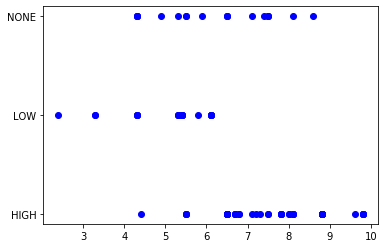

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(targetBaseScore[0:100],targetConfidImpact[0:100],"bo")

#pandasDF.loc[116]

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Onehot ==> Linéaire
# Ordinal = Treebased

model = make_pipeline(OneHotEncoder(),LinearRegression())
model

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv = 10)


/Users/nicolassigal/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: setting an array element with a sequence.

  FitFailedWarning)
/Users/nicolassigal/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: setting an array element with a sequence.

  FitFailedWarning)
/Users/nicolassigal/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: setting an array element with a sequence.

  FitFailedWarning)
/Users/nicolassigal/opt/anaconda3/lib/python3.7/site-packages/sklea

In [ ]:
cv_results["test_score"].mean()

nan